##  Nanowire Network Models

Author: Alon Loeffler

Required Files/Folders: learning_functions.py | edamame | asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00


Here we load nanowire networks built using 'multi_generate_networks.py' and 'wires.py' in /PhysicalReinforcementLearning/generate_networks/, visualise the networks and define input and outputs electrodes.

In [1]:
#IMPORTS 
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('../../edamame') #point to edamame locally
saveFig='../../Data/Figures/'  #Define Figure Save location (not in github repo)

from edamame import * 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import copy

from scipy.io import loadmat, savemat

#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph


In [9]:
# # GENERATE + LOAD CSV FILE OF IMAGES:
# from learning_functions import generate_data, load_data
# N= 9
# generate_data(N)
# inputs,onehot_outputs,sample_num,targets=load_data(N)
# target_letters=['z','v','n']
# inv_inputs = np.linalg.pinv(inputs)
# inputs=inputs[:,:-1]


In [10]:
#Create Sample Input Cue Patterns

np.random.seed(42)
numSamples=10
#SIMPLE ROW INPUTS:
np.random.seed(42)
orig_inputs=np.array((np.array([1,0,1,1,0,1,0,1,0]),np.array([0,1,0,1,1,0,1,1,0])))
orig_inputs=orig_inputs.astype('double')
samples=[[] for i in range(len(orig_inputs))]
new_inputs=np.array([orig_inputs]*numSamples)

#Pattern without Noise
NoNoiseInputs=[]
for targetClass in range(len(orig_inputs)):
    NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])

#Make Noisy variants of simple patterns:
for i in range(len(orig_inputs)):
    for j in range(numSamples):
        randVals=np.random.randint(1,3) #choose how many of the 3 sources will have noise
        noiseVals=np.random.randint(3, size=randVals)
        temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
        for val in noiseVals:
            temp[val]=np.double(np.random.random(1))
        new_inputs[j][i][new_inputs[j][i]==1]=temp
#         samples[i].append(temp)

#RESHAPE INPUTS INTO numSamplesx2
row1=[]
row2=[]
for i in range(len(new_inputs)):
    row1.append(new_inputs[i][0])
    row2.append(new_inputs[i][1])

inputs=np.array([row1,row2])
inputs=inputs.reshape(numSamples*2,orig_inputs.shape[1])
targets=np.zeros(numSamples*2)
targets[-numSamples:]=1

#change 0 volts to 0.05
minVoltage=0.005
inputs=inputs+minVoltage


In [13]:
#LOAD NETWORKS GENERATED IN 'multi_generate_networks.py' and 'wires.py'

#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#asn_nw_00350_nj_01400_seed_2665_avl_10.00_disp_01.00_lx_50.00_ly_50.00
#asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00
# nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
nw=loadmat('/PhysicalReinforcementLearning/generate_networks/Network Data/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [14]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

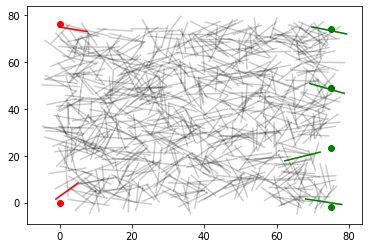

In [18]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]
numSources = 4
nwSize = 700
#Pick Electrode placement/distance apart:

#DRAINS
numDrains=2
exD=np.zeros(numDrains)*5#*15
if nwSize > 500:
    eyVal=76
else:
    eyVal= 51
eyD=np.linspace(-0,eyVal,numDrains)#(-1,101,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,exD,eyD) #generate drain locations in ex, ey coordinates



#PLACE ELECTRODES IN AN EQUIDISTANT LINE:
if nwSize > 500:
    exVal=75
    eyVal = 74
else:
    exVal=50
    eyVal=49
ex=np.ones(numSources)*exVal#50
ey=np.linspace(-2,eyVal,numSources)#(-2,99,numSources)

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates


# Manual Source/Drain Override (if needed):
if numSources==9:
    if nwSize > 500:
        elecSource=[678, 260, 491, 173, 628, 424, 301, 236, 483] #700nws
#     else:
#         elecSource=[23,320,194,74, 145, 317, 129, 34, 141] #350 nws

# elif numSources == 4:
#     elecSource=[320,42,161,141]

#     else:    #remove middle drain and sources for simple patterns: if 350 nws
#         if numSources==7:
#             elecSource=elecSource[[0,1,2,4,6,7,8]]
# elecDrain=elecDrain[[0,-1]]
plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')
plt.scatter(exD, eyD, c = 'r')

plt.savefig(saveFig+'698w2582j_network_4inputs_2drains.pdf',format='pdf',dpi=300)

In [31]:
#Manually change drains and sources and visualise where they are

print('OG Sources:' + str(elecSource))
print('OG Drains:' + str(elecDrain))


#remove middle drain and sources for simple patterns:


# elecSource=elecSource[[0,1,2,4,6,7,8]]
# elecDrain=elecDrain[[0,-1]]

#4 electrodes:
elecSource=[678, 421, 207, 483]#[431, 200, 491, 126, 546, 423, 558]

#9 electrodes:
#elecSource=[678, 260, 491, 173, 628, 424, 301, 236, 483]

OG Sources:[678, 421, 207, 550]
OG Drains:[600 399]


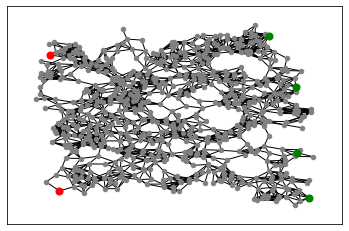

In [33]:
#Graphical Representation of Network
fig=plt.figure()#figsize=(20,20))
g=nx.from_numpy_array(connectivity.adj_matrix)
pos=nx.kamada_kawai_layout(g)
nx.draw_networkx(g,pos=pos,node_color='grey',with_labels=False,node_size=20)

nx.draw_networkx_nodes(g,pos=pos,nodelist=elecSource,node_color='g',node_size=50)
nx.draw_networkx_nodes(g,pos=pos,nodelist=elecDrain,node_color='r',node_size=50)
# nx.draw_networkx_nodes(g,pos=pos,nodelist=[elecDrain[0]],node_color='r',node_size=50)

plt.show()
# fig.savefig(saveFig+'698w2582j_network_7drains_graphical.pdf',format='pdf',dpi=300)


In [259]:
#Save examples of generated patterns
orig_inputs=np.array((np.array([1,0,1,0,0,1,0,0,0]),np.array([0,0,0,1,0,0,1,0,1])))

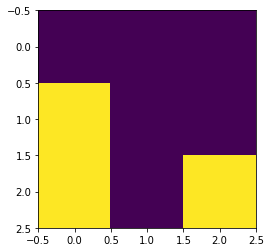

In [262]:
plt.imshow(orig_inputs[1].reshape(3,3))
plt.savefig(saveFig+'Input2.pdf',format='pdf',dpi=300)